In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random


In [2]:
def make_click_prob(doc_theta, ad_prob, num_docs, num_ads):
    
    p_ads = np.dot(np.ones(num_ads), ad_prob)
    
    cvec = np.dot(np.ones(num_docs), doc_theta)
    
    cvec_prod = np.cumprod(cvec)
    cvec_prod = np.pad(cvec_prod,(1,0),'constant',constant_values=(1.0))
    w1 = np.divide( 1.0, np.sum(cvec_prod))
    w_tail = np.multiply(cvec_prod[1:len(cvec_prod)],w1)
    p_docs = np.append(w1, w_tail[0:num_docs-1])
    
    p_both = np.concatenate([p_ads,p_docs])
    # click prob without ads
    click_prob =  np.divide(p_both, np.sum(p_both)).tolist()
   
    return click_prob


def is_budget_available(budgets, num_ads, ad_cost):
    if np.sum(budgets) >  num_ads * ad_cost:
        return True
    else:
        return False


def select_provider_ads(budgets, num_ads, ad_cost):
    # returns a list containing number of ads - randomly picked from providers with enough budget to pay for the ad
    possible_providers = []
    
    for i in range(0,len(budgets)):
        
        if budgets[i] > ad_cost:
            possible_providers.append(i)
    
    random.shuffle(possible_providers)
    if len(possible_providers) < num_ads:
        num_ads = len(possible_providers)
    return possible_providers[0:num_ads]


def get_clicked_item(click_probs):
    p = random.random()
    ps = click_probs[1]
    i = 0
    while  (p > ps) and (i<len(click_probs)-1):
        i = i + 1
        ps = ps + click_probs[i]
 
    return i


def get_provider_ranking(clicks):   
    ranking = sorted(clicks, key=clicks.__getitem__, reverse=True)
    return ranking


def cap_budget(ad_budget):
    
    max1=0
    index1 = 0
    max2=0
    index2 = 0
    for i,value in enumerate(ad_budget):
        if value > max1:
            max2 = max1
            index2 = index1
            max1=value
            index1=i
            
    ad_budget[index1] = min(max2*2, max1)
    return ad_budget


In [3]:
# Per Round
def do_round(capital, costs, clicks):

    #Initialize Round
    ad_budgets = np.multiply(np.multiply(np.ones(n), ad_percent), capital).tolist()
    
    ad_budgets = cap_budget(ad_budgets)
    
    ad_spend = np.zeros(n).tolist()  
    rev_clicks = np.zeros(n).tolist()  

    for i in range(0,n_requests):
        # check ad budget, any left given provider budgets?
        ad_providers = []
        if is_budget_available(ad_budgets, n_ads, ad_cost):
            # select ads from n_ad providers
            ad_providers = select_provider_ads(ad_budgets, n_ads, ad_cost)
            # set number of ads in the round
            num_ads = len(ad_providers)
        else:
            num_ads = 0
    
        # construct the click prob list
        click_probs = make_click_prob(doc_theta, ad_prob, n, num_ads) 
    
        # make ranking of providers
        ranked_providers = get_provider_ranking(clicks)
        
        # pick the doc clicked
        item_clicked = get_clicked_item(click_probs)
    
        if item_clicked < num_ads:
            clicked_provider = ad_providers[item_clicked]
            ad_budgets[clicked_provider] = ad_budgets[clicked_provider] - ad_cost
            ad_spend[clicked_provider] = ad_spend[clicked_provider] + ad_cost
        else:
            # need to adjust for the position of the ads in the list. hack..
            # maybe make a prob to click an ad, and then a prob to click the position
            #print(i,item_clicked, num_ads)
            clicked_provider = ranked_providers[item_clicked-num_ads]
        
        # record the click in total clicks list
        clicks[clicked_provider] =  clicks[clicked_provider] + 1
        # record the number of clicks this round list
        rev_clicks[clicked_provider] = rev_clicks[clicked_provider] + 1
    
    # end of round
    revenue = np.multiply(np.array(rev_clicks), conversion_rate*profit)
    #print("capital", capital)
    #print(costs)
    #print("budgets",ad_budgets)
    #print(ad_spend)
    #print(revenue)
    
    # capital - ad_spend - running_costs + revenue
    capital = np.add(np.subtract(np.subtract(capital, costs), np.array(ad_spend)),revenue)
    
    return (capital, costs, ad_spend, revenue, clicks)
    
#print("capital", capital)
 


In [32]:
starting_capital = 1000
n = 30
capital = np.add(np.multiply(np.multiply(np.ones(n),starting_capital),np.random.rand(n)),100)
print("Starting Capital: ", np.sum(capital))
print(capital)

Starting Capital:  18454.1161477
[  880.71746914   204.38087158   533.53568332   680.2543848   1004.14827411
   694.09008708   197.60737644   271.00221041   188.99593427   399.92150076
   637.05038879   558.34674888  1093.45714397   238.77513016   101.21683384
   876.05869876  1006.3035268    351.44613001  1077.87155713   607.47655119
  1069.18250016   386.75104998   937.97673594   672.22322964   602.03180868
   347.90559925   919.17678962   921.85450205   104.20508747   890.15234343]


In [33]:
# initalize the scenario
running_costs = 2
ad_percent = 0.05
ad_cost = 0.5
n_ads = 3
n_requests = 1000
conversion_rate = 0.05
profit = 30.0
doc_theta = 0.4
ad_prob = 0.3

providers = list(range(1,n))
# assumes running costs are fixed every round
costs = np.multiply(np.ones(n), running_costs)

# initialize with some clicks.. 100 to 0 / used to rank the sites.
clicks = {}
for i in range(0,n):
    clicks[i] = random.randint(0,100)
    
#cp = make_click_prob(doc_theta, ad_prob, n, n_ads)
print(providers)
#print("capital", capital)

tcap = []
tcap.append(capital)
tad = []
talive = []

for r in range(0,365):
    (capital, costs, ad_spend, revenue, clicks) = do_round(capital, costs, clicks)
    costs = np.multiply(np.multiply(np.ones(n), 0.01), capital)
    
    tcap.append(capital)
    
    alive = 0
    for c in list(capital):
        if c > 100:
            alive = alive + 1
    talive.append(alive)
            
    tad.append(np.sum(np.array(np.array(ad_spend))))

print(alive)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
30


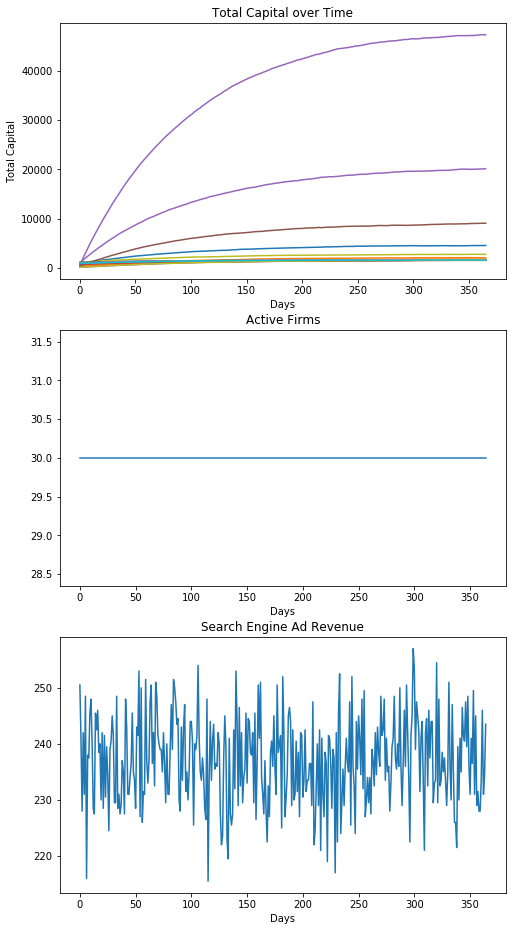

Ending Capital:  123522.628596
Total Ad Revenue Over Period: 86549.5


In [34]:
ntcap = np.array(tcap)

plt.figure(figsize =(8,16))
plt.subplot(3, 1, 1)
plt.plot(ntcap)
plt.title("Total Capital over Time")
plt.xlabel("Days")
plt.ylabel("Total Capital")

plt.subplot(3, 1, 2)
plt.plot(talive)
plt.title("Active Firms")
plt.xlabel("Days")

plt.subplot(3, 1, 3)
plt.plot(tad)
plt.title("Search Engine Ad Revenue")
plt.xlabel("Days")
plt.show()

print("Ending Capital: ",  list(np.sum(ntcap, axis=1))[-1])
print("Total Ad Revenue Over Period:",  np.sum(tad))

In [7]:

click_probs = make_click_prob(doc_theta, ad_prob, 10, 3) 
len(click_probs)

13

In [8]:
capital

array([ 1179.74845459,    43.33314851,    65.94528767,    84.07082149,
         170.7178168 ,   110.59958014,    81.18930078,  1349.29472823,
         666.73275284,    93.14685795,    32.68648484,   560.53183151,
         419.94015479,   770.42457405,   145.07341198,  1022.56716423,
         107.65623845,    61.72293305,   132.31509248,   339.55221031,
         234.90465486,  1536.82184106,    74.31867529,   189.32504335,
         180.74660538,    49.35582666,    49.66444204,   277.11966521,
         898.12995505,   478.78085294])

In [9]:
Ending Capital:  13178.718107
Total Ad Revenue Over Period: 82111.0
    
1 ad
Ending Capital:  17290.7463967
Total Ad Revenue Over Period: 68415.0

2 Ads
Ending Capital:  16219.4244348
Total Ad Revenue Over Period: 68488.5
    
3 Ads
    Ending Capital:  14794.4664774
Total Ad Revenue Over Period: 77673.0

5 ads
Ending Capital:  13311.82866
Total Ad Revenue Over Period: 83770.0
    
    10 Ads
    Ending Capital:  12492.1877655
Total Ad Revenue Over Period: 85977.0
    
    15 Ads
    Ending Capital:  12070.3157802
Total Ad Revenue Over Period: 86148.0
    25
    Ending Capital:  12001.4164819
Total Ad Revenue Over Period: 87093.5
    
    Ending Capital:  14545.8394544
Total Ad Revenue Over Period: 75558.5

SyntaxError: invalid syntax (<ipython-input-9-522df65e3cee>, line 1)